# Reducing Privacy of CoinJoin Transactions:  <br />  Quantitative Bitcoin Network Analysis

#### by Anton Wahrstätter, Alfred Taudes and Davor Svetinovic

## Steps
1. [Data collection](#1.-Data-collection)
2. [Data preparation](#2.-Data-preparation)
3. [Data Analysis](#3.-Data-Analysis)  
    3.1. [Load Data](#3.1.-Load-data)  
    3.2. [General Stats](#3.2.-General-Stats)  
    3.3. [CoinJoin-adjusted User Graph](#3.3-Bitcoin---CoinJoin-adjusted-User-Graph)  
    3.4. [Network Properties](#3.4.-Network-Properties)  
    3.5. [Additional Material](#3.5.-Additional-Material)


***

## 1. Data collection

https://github.com/Nerolation/python-bitcoin-scraper

***

## 2. Data preparation 
### The data preparation steps has been carried out using SQL (BigQuery). To recap, the following steps were taken to transform the transaction graph into a CoinJoin-adjusted usergraph:
   * Partition table into yearly chunks
   * Create separate table that doesn't include coinbase tx and txs with OP_Returns or invalid output scripts
   * Create Address => ID mapping
   * Create Tx => ID mapping
   * Use mappings to reconstruct the transaction graph (reduces size massively)
   * Detect Wasabi CoinJoin Transaction IDs
   * Detect Samurai CoinJoin Transaction IDs
   * Create table containing a CoinJoin filtered transaction graph 
   * Copy Address => ID mapping, clone the ID column and add it with the column name ``clusterid``
   * Create list of ``linking_IDs`` which are IDs of transactions that can be linked through a common input address
   * Perform user clustering - on the standard (not adjusted) usergraph and the CoinJoin-adjusted usergrah
   * Create final user graph


## 3. Data Analysis

In [1]:
import os 
import math
import numpy as np
import pandas as pd
from datetime import datetime
from google.cloud import storage, bigquery
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica"
})

pd.options.display.float_format = '${:,.2f}'.format
pd.options.mode.chained_assignment = None
    
credentials_path = "./.gcpkey/btcgraph.json"
bq_project       = "wu-btcgraph"
bq_dataset       = "btc"

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credentials_path

if not os.path.isdir("./pictures"):
    os.mkdir("./pictures")

# Least Sqare Line 
# E(t) = N(t)^a

def least_squares_line(cnc, cec, n = None):
    if n:
        cnc = cnc[-n:]
        cec = cec[-n:]
    
    ln_x = list(map(math.log, cnc))
    ln_y = list(map(math.log, cec))

    
    mean_ln_x = np.mean(ln_x)
    mean_ln_y = np.mean(ln_y)

    xi_x = list(map(lambda x: x - mean_ln_x, ln_x))
    yi_y = list(map(lambda x: x - mean_ln_y, ln_y))        
    
    xi_x_yi_y = list(map(lambda x,y: x*y, xi_x, yi_y))
    xi_x2     = list(map(lambda x: x**2, xi_x))

    powerlaw_e = sum(xi_x_yi_y)/sum(xi_x2)
    constant   = math.exp(mean_ln_y - powerlaw_e*mean_ln_x)
    return powerlaw_e, constant

    #print("Densification power law exponent of {:.3f} with a constant of {:.3f}".format(powerlaw_e,constant))
    #print("Equation: y = {:.3f}**{:.3f}".format(constant,powerlaw_e))


def get_fitting_result(X, Y, plot_figure=False, fit_intercept=True):

    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_ = poly.fit_transform(X.reshape(-1, 1))

    clf = linear_model.LinearRegression(fit_intercept=fit_intercept)
    clf.fit(X_, Y)
    Y_NEW = clf.predict(X_)
    if plot_figure:
        plt.gca().set_yscale('log')
        plt.gca().set_xscale('log')
        plt.scatter(X, Y)
        plt.plot(X, Y_NEW)

    rmse = np.sqrt(mean_squared_error(Y,Y_NEW))
    r2 = r2_score(Y,Y_NEW)

    print(f"RMSE: {rmse}")
    print(f"R²:   {r2}")
    equation = "${:,.0f} + {:,.2f}x {:,.3f}x^2\ \mid\ R^2 = {:,.2f}$".format(clf.intercept_,clf.coef_[0],clf.coef_[1], r2)
    return equation, Y_NEW, (clf.intercept_, clf.coef_[0], clf.coef_[1])

### 3.1. Load data

In [2]:
USE_LOCAL_COPIES_IF_POSSIBLE = False
CREATE_LOCAL_COPIES = True
def query(bq_table):
    _query = """
            SELECT    * 
            FROM      `{}.{}.{}`
            """.format(bq_project,bq_dataset,bq_table)
    return _query

QUERIES = ["stats_invalids", "stats_metrics_summary_per_month_pubk", 
           "stats_metrics_summary_per_month_user_WCJ", 
           "stats_metrics_summary_per_month_user_UG", "stats_general_metrics",
           "stats_user_count_cum_UG", "stats_user_count_cum_WCJ", 
           "stats_degree_distribution_total_UG", "stats_degree_distribution_in_degree_UG", 
           "stats_degree_distribution_out_degree_UG", 
           "stats_degree_distribution_total_WCJ", "stats_degree_distribution_in_degree_WCJ", 
           "stats_degree_distribution_out_degree_WCJ", "stats_blk_files", 
           "coinj_metrics_over_time", "stats_active_time_G", 
           "stats_active_time_WCJ", "coinj_stats", "stats_last_tx",
           "usergraph_clustersizes_distribution_UG", "services_all",
           "usergraph_clustersizes_distribution_WCJ", "stats_summary", 
           "stats_avg_outdegree_UG", "stats_avg_outdegree_WCJ", "stats_coinbase",
           "coinj_total_per_provider", "stats_coinj_vs_total_edges_blk",
           "stats_largest_cluster_services", "stats_2nd_largest_cluster_services",
           "stats_3rd_largest_cluster_services","stats_active_time_avg_G",
           "stats_active_time_avg_WCJ", "stats_most_active_public_key",
           "stats_degree_in_largest_services_UG", "stats_degree_in_largest_services_WCJ",
           "stats_degree_out_largest_services_UG", "stats_degree_out_largest_services_WCJ"] 

if USE_LOCAL_COPIES_IF_POSSIBLE:
    try:
        DF
    except:
        DF = {}
else:
    DF = {}

for bq_table in QUERIES:
    try:
        if not USE_LOCAL_COPIES_IF_POSSIBLE:
            raise
        DF[bq_table] = pd.read_csv(".local_copies/" + bq_table + ".csv")
        print("{:<49} read from local storage".format(bq_table))

    except:
        try:
            DF[bq_table]
            pass
        except KeyError:
            DF[bq_table] = pd.read_gbq(query(bq_table), bq_project, reauth=True)
            print("{:<49} read from Google BigQuery".format(bq_table))

print(f"{len(DF)} tables successfully loaded into the RAM")

# Make local copies
if CREATE_LOCAL_COPIES:
    for table in DF:
        DF[table].to_csv(".local_copies/" + table + ".csv", index=None)

stats_invalids                                    read from Google BigQuery
stats_metrics_summary_per_month_pubk              read from Google BigQuery
stats_metrics_summary_per_month_user_WCJ          read from Google BigQuery
stats_metrics_summary_per_month_user_UG           read from Google BigQuery
stats_general_metrics                             read from Google BigQuery
stats_user_count_cum_UG                           read from Google BigQuery
stats_user_count_cum_WCJ                          read from Google BigQuery
stats_degree_distribution_total_UG                read from Google BigQuery
stats_degree_distribution_in_degree_UG            read from Google BigQuery
stats_degree_distribution_out_degree_UG           read from Google BigQuery
stats_degree_distribution_total_WCJ               read from Google BigQuery
stats_degree_distribution_in_degree_WCJ           read from Google BigQuery
stats_degree_distribution_out_degree_WCJ          read from Google BigQuery


/home/nero/python/wu/btc/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1967: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  df[column] = pandas.Series(df[column], dtype=dtypes[column])


stats_blk_files                                   read from Google BigQuery
coinj_metrics_over_time                           read from Google BigQuery
stats_active_time_G                               read from Google BigQuery
stats_active_time_WCJ                             read from Google BigQuery
coinj_stats                                       read from Google BigQuery
stats_last_tx                                     read from Google BigQuery
usergraph_clustersizes_distribution_UG            read from Google BigQuery
services_all                                      read from Google BigQuery
usergraph_clustersizes_distribution_WCJ           read from Google BigQuery
stats_summary                                     read from Google BigQuery
stats_avg_outdegree_UG                            read from Google BigQuery
stats_avg_outdegree_WCJ                           read from Google BigQuery
stats_coinbase                                    read from Google BigQuery
coinj_total_

***

### 3.2. General Stats

In [3]:
# Table in LATEX format
df_cnc = DF["stats_general_metrics"].sort_values("year").set_index("year")
print("snapshot & \#txs & \#edges & \#nodes \\\ \n\hline")
for i,j in df_cnc.iterrows():
    print("31.12."+str(i)+" &", " & ".join(["{:,.0f}".format(int(jj)) for jj in j])+" \\\ ")

snapshot & \#txs & \#edges & \#nodes \\ 
\hline
31.12.2009 & 32,709 & 36,118 & 32,611 \\ 
31.12.2010 & 218,012 & 357,980 & 176,326 \\ 
31.12.2011 & 2,119,777 & 8,699,936 & 2,768,497 \\ 
31.12.2012 & 10,572,827 & 50,619,652 & 8,707,387 \\ 
31.12.2013 & 30,216,068 & 165,406,409 & 24,806,749 \\ 
31.12.2014 & 55,479,788 & 536,722,857 & 58,880,264 \\ 
31.12.2015 & 101,153,811 & 1,104,704,739 & 115,225,325 \\ 
31.12.2016 & 183,780,434 & 1,707,653,884 & 209,678,116 \\ 
31.12.2017 & 287,843,663 & 2,769,993,445 & 353,414,610 \\ 
31.12.2018 & 369,239,299 & 3,615,499,650 & 464,829,692 \\ 
31.12.2019 & 489,022,946 & 4,747,563,790 & 595,594,675 \\ 
31.12.2020 & 601,576,444 & 5,931,290,239 & 759,260,121 \\ 
31.12.2021 & 686,642,867 & 7,427,788,006 & 901,545,413 \\ 


#### Last transaction

In [4]:
DF["stats_last_tx"]

,ts,tx_id,blk_file_nr
0,2021-11-14 04:57:14+00:00,aeec2e652b39288b623a0c58bb3a68a696f87ff52227d3...,2804


#### Transaction Overview

In [5]:
# Invalid transactions/OP_RETURNs
for i, j in DF["stats_invalids"].iterrows():
    print("{:<10}: {:>10,} edges  {:>10,} txs".format(j.address, j.edges, j.txs))
 

df = DF["stats_coinbase"]
print("{:<10}: {:>10,} edges  {:>10,} txs (excl. +2 tx with similar tx hashes)".format("coinbase", int(df.coinbase_edges), int(df.coinbase_txs)))

df = DF["stats_invalids"].set_index("address")
invalids = df.loc["invalid", "txs"] + df.loc["unknown", "txs"]
print("\n{:<10}: {:>10,} %".format("Valid  txs",round((1-invalids/df_cnc.iloc[-1]["txs_c"])*100,2)))
print("\nCoinJoins :")
sam = int(DF["coinj_total_per_provider"][DF["coinj_total_per_provider"]["name"]=="samurai"]["txs"])
was = int(DF["coinj_total_per_provider"][DF["coinj_total_per_provider"]["name"]=="wasabi"]["txs"])
print("{:<10}: {:>10,} txs".format("total",was+sam))
print("{:<10}: {:>10,} txs".format("wasabi",was))
print("{:<10}: {:>10,} txs".format("samurai",sam))

invalid   :      9,175 edges       9,162 txs
opreturn  : 64,739,214 edges  49,485,398 txs
unknown   :    258,180 edges     221,177 txs
coinbase  :  2,705,043 edges     709,630 txs (excl. +2 tx with similar tx hashes)

Valid  txs:      99.97 %

CoinJoins :
total     :    104,177 txs
wasabi    :     21,414 txs
samurai   :     82,763 txs


#### Users in UG-CJ

In [6]:
# Users and their transactions

a = DF["stats_user_count_cum_WCJ"].set_index("year").loc[2021,:]
for i in a.iteritems():
    print("{:<6} {:,.0f}".format(i[0].strip("_c")+":",i[1]))
    
DF["services_all"]

txs:   685,316,007
edges: 1,820,539,209
addrs: 415,067,228


,service
0,Bitfloor
1,Coingi.com
2,Ransomware
3,HelixMixer-old3
4,Doublebitcoin.cc
...,...
709,Bitstamp
710,Btcc pool
711,AllCrypt.com
712,Bitstamp.net


#### CoinJoins


In [7]:
# Table in LATEX format
df_cnc = DF["coinj_stats"].set_index("name")
wasabi = df_cnc.loc["wasabi"]
samurai = df_cnc.loc["samurai"]



print("&$ \sum{out} $& $\overline{out}$ & $\#\ txs $& $\sum{edges}$ & $\overline{\#out}$ \\\ \n\hline")

print(wasabi.name+" &", "{:,.0f} & {:,.0f} & {:,.0f} & {:,.0f} & {:,.0f} \\\ ".format(
     wasabi["avg_value"], 
     wasabi["total_value"],
     wasabi["total_txs"],
     wasabi["total_edges"],
     wasabi["avg_nr_outputs"]))

print(samurai.name+" &", "{:,.2f} & {:,.0f} & {:,.0f} & {:,.0f} & {:,.0f}".format(
     samurai["avg_value"], 
     samurai["total_value"],
     samurai["total_txs"],
     samurai["total_edges"],
     samurai["avg_nr_outputs"]))


&$ \sum{out} $& $\overline{out}$ & $\#\ txs $& $\sum{edges}$ & $\overline{\#out}$ \\ 
\hline
wasabi & 18 & 405,245 & 21,414 & 222,597,392 & 119 \\ 
samurai & 0.24 & 20,013 & 82,763 & 2,069,075 & 5


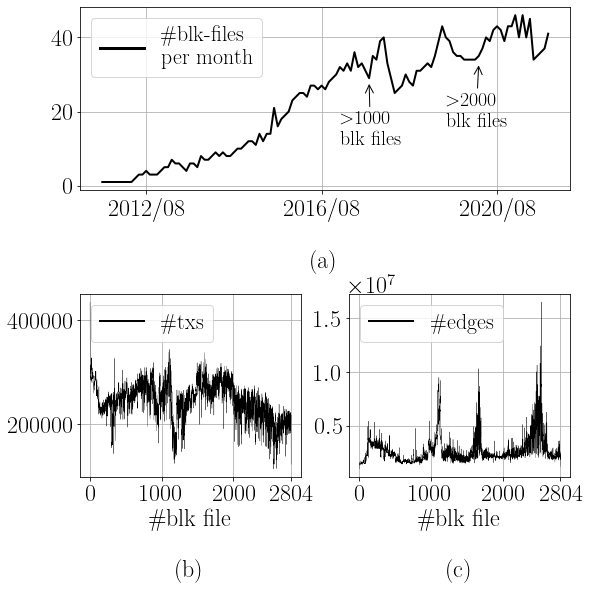

2369: 25% coinjoin edges in blk file
1782: 22% coinjoin edges in blk file
2264: 22% coinjoin edges in blk file


In [8]:
# Transactions and edges per blk file

df_blkfiles = DF["stats_blk_files"]
df_blkfiles["timestamp"] = list(map(lambda x: x.strftime("%Y/%m"), df_blkfiles["ts"]))
df_blkfiles_gr = df_blkfiles.groupby(["timestamp"]).size()[:-1]
df_coinj_edges = DF["stats_coinj_vs_total_edges_blk"]["coinj_edges"]

# SMAs (optional)
#df_blkfiles_ma_index = df_blkfiles.groupby(df_blkfiles.index // 200).mean()["blk_file_nr"]
#df_blkfiles_ma_edges = df_blkfiles.groupby(df_blkfiles.index // 200).mean()["edges"]
#df_blkfiles_ma_txs = df_blkfiles.groupby(df_blkfiles.index // 200).mean()["txs"]
# Create figure with size 5x3.15 inches
f, axs = plt.subplot_mosaic([['2', '2'],
                             ['0', '1']],
                              figsize=(8, 8))

# Plot chart
axs["0"].plot(df_blkfiles["blk_file_nr"],df_blkfiles["txs"], color="k", linewidth = 0.3, label="\#txs")
axs["1"].plot(df_blkfiles["blk_file_nr"],df_blkfiles["edges"], color="k", linewidth = 0.3, label="\#edges")
axs["2"].plot(df_blkfiles_gr.index,df_blkfiles_gr, color="k", linewidth = 2, label="\#blk-files\nper month")
#axs["1"].plot(df_blkfiles["blk_file_nr"],df_coinj_edges, color="#00629b", linewidth = 2, label="sma (k=10)")
#axs["0"].plot(df_blkfiles_ma_index,df_blkfiles_ma_txs, color="#00629b", linewidth = 2, label="sma (k=10)")


# Customize ticks and labels
axs["0"].tick_params(axis='both', which='major', labelsize=24)
axs["1"].tick_params(axis='both', which='major', labelsize=24)
axs["2"].tick_params(axis='both', which='major', labelsize=24)

axs["0"].xaxis.set_ticks([0,1000,2000,df_blkfiles["blk_file_nr"].iloc[-1]])
axs["1"].xaxis.set_ticks([0,1000,2000,df_blkfiles["blk_file_nr"].iloc[-1]])
axs["2"].xaxis.set_ticks(np.arange(12, 124, 48))

axs["0"].set_xlabel("\#blk file\n\n(b)", fontsize=24)
axs["1"].set_xlabel("\#blk file\n\n(c)", fontsize=24)
axs["2"].set_xlabel("\n(a)", fontsize=24)

axs["1"].yaxis.get_offset_text().set_fontsize(24)

axs["2"].annotate("$>$1000 \nblk files", xy=("2017/09", 28), xycoords='data',
            xytext=("2017/01", 11), textcoords='data',size=20,
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))
axs["2"].annotate("$>$2000\nblk files", xy=("2020/03", 33), xycoords='data',
            xytext=("2019/06", 16), textcoords='data',size=20,
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))

# Legend
lgnd1 = axs["0"].legend(fontsize=22, loc="upper left")
lgnd2 = axs["1"].legend(fontsize=22)
lgnd3 = axs["2"].legend(fontsize=22)

lgnd1.legendHandles[0]._linewidth = 2
lgnd2.legendHandles[0]._linewidth = 2
lgnd3.legendHandles[0]._linewidth = 3
plt.tight_layout(pad=0)
#Save figure and show
plt.savefig("./pictures/blk_files.pdf")
plt.show()
largest_shares = DF["stats_coinj_vs_total_edges_blk"].sort_values("share", ascending=False).iloc[0:3]
for _, i in largest_shares.iterrows():
    print(str(int(i["blk_file_nr"])) + ": " + str(int(i["share"])) + "% coinjoin edges in blk file")

### 3.3 Bitcoin - CoinJoin-adjusted User Graph

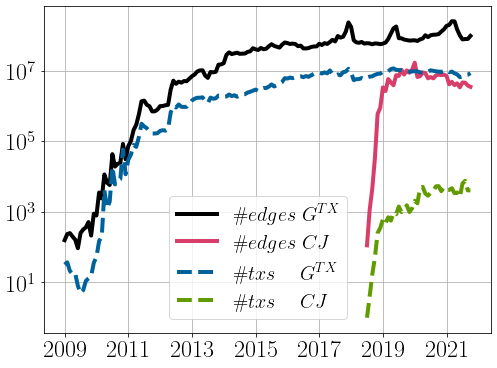

In January 2020, CoinJoin edges account for 23.22 % of the total number of edges


In [9]:
# (CoinJoin) Transaction/Edges per Month

df_edges  = DF["stats_metrics_summary_per_month_pubk"][:-1][["year","month","edges"]]
df_txs    = DF["stats_metrics_summary_per_month_pubk"][:-1][["year","month","txs"]]
df_cj_all = DF["coinj_metrics_over_time"][:-2]

# Create figure
plt.figure(figsize=(8, 6))

# Join year and month to get month-of-year `moy`
for i, j in zip(df_edges["year"], df_edges["month"]):
    df_edges.loc[(df_edges["year"].isin([i])) & (df_edges["month"].isin([j])),'moy'] = str(i)+"/"+str(j)

    
for i, j in zip(df_cj_all["year"], df_cj_all["month"]):
    df_cj_all.loc[(df_cj_all["year"].isin([i])) & (df_cj_all["month"].isin([j])),'moy'] = str(i)+"/"+str(j)
    
cjmoy = df_cj_all["moy"].drop_duplicates()

cjedges = df_cj_all.groupby(["year", "month"]).sum().reset_index()["edges"]
cjtxs = df_cj_all.groupby(["year", "month"]).sum().reset_index()["txs"]


# Plot chart
plt.plot(df_edges["moy"],df_edges["edges"], color="k", linewidth=4)
plt.plot(cjmoy,cjedges, color="#d93e6a", linewidth=4)
plt.plot(df_edges["moy"],df_txs["txs"], color="#00629b", linestyle='dashed', linewidth=4)
plt.plot(cjmoy,cjtxs, color="#629b00", linestyle='dashed', linewidth=4)


# Customize ticks and labels
ticks_position = list(set([i+"/1" for i in df_edges["year"].astype(str) if int(i) % 2 != 0]))
ticks          = [r"{}".format(tick.split("/")[0]) for tick in ticks_position]
plt.xticks(ticks_position, ticks, fontsize=24)
plt.yticks(fontsize=24)
plt.yticks(fontweight="book")
plt.gca().set_yscale('log')


# Legend
plt.legend([r"$\#edges\ G^{TX} \ $", r"$\#edges\ CJ$",
            r"$\#txs\ \ \ \ G^{TX}$", r"$\#txs\ \ \ \ CJ$"], 
          fontsize=20,loc='best', bbox_to_anchor=(0.7,0.45))

#Save figure and show
plt.savefig("./pictures/txs_edges_over_months_log.pdf")
plt.show()

cl_per_edges = round(cjedges.iloc[18]/df_edges.iloc[132]["edges"]*100, 2)
print(f"In January 2020, CoinJoin edges account for {cl_per_edges} % of the total number of edges")

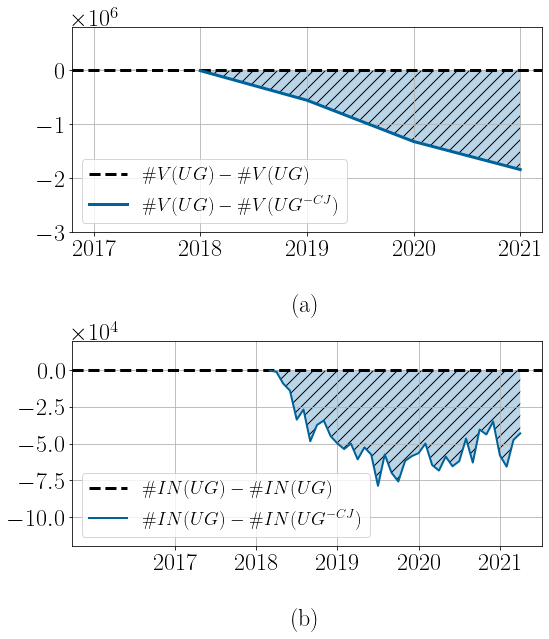

Final difference between the user graphs: -1,837,417 users


In [10]:
df_ent_sum = DF["stats_summary"]
df_user    = DF["stats_metrics_summary_per_month_user_WCJ"][:-1][["year","month","active_users"]]
df_user_ug = DF["stats_metrics_summary_per_month_user_UG"][:-1][["year","month","active_users"]]
df_pubk    = DF["stats_metrics_summary_per_month_pubk"][:-1][["year","month","active_users"]]


df_user["moy"] = df_user["year"].astype(str)  + "/" + df_user["month"].astype(str) 


# Create figure 
f, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 9),
                       gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [3, 3]})

# Plot charts
axs[1].axhline(0, color='black', lw=3, linestyle="dashed", label=r"$\# IN(UG)-\# IN(UG)$")
axs[1].plot(df_user["moy"][-64:],df_user_ug["active_users"][-38:]-df_user["active_users"][-64:], color="#00629b",
            label=r'$\# IN(UG)-\#IN(UG^{-CJ})$',linewidth=2)
axs[1].fill_between(df_user["moy"][-64:],df_user_ug["active_users"][-64:]-df_user["active_users"][-64:], alpha=0.3, hatch=r"//")


axs[0].axhline(0, color='black', lw=3, linestyle="dashed", label=r"$\# V(UG)-\# V(UG)$")
axs[0].plot(df_ent_sum["year"][8:],df_ent_sum["users"][9:]-df_ent_sum["users_wcj"][8:], 
            color="#00629b", label=r'$\# V(UG) - \# V(UG^{-CJ})$',linewidth=3)
axs[0].fill_between(df_ent_sum["year"][8:],df_ent_sum["users"][8:]-df_ent_sum["users_wcj"][8:], alpha=0.3, hatch=r"//")


# Customize ticks and labels
axs[1].xaxis.set_ticks(["2017/7","2018/7","2019/7","2020/7","2021/7"])
axs[1].yaxis.set_ticks([0,-25000,-50000,-75000,-100000])
axs[1].set_xticklabels(["2017","2018","2019", "2020","2021"])
axs[1].yaxis.get_offset_text().set_fontsize(24)
axs[1].tick_params(axis='both', which='major', labelsize=24)
axs[1].set_ylim(-12e4,2e4)
axs[1].ticklabel_format(axis="y", style="sci", scilimits=(4,4))
axs[0].yaxis.get_offset_text().set_fontsize(24)
axs[0].set_ylim(-3e6,0.8e6)
axs[0].tick_params(axis='both', which='major', labelsize=24)
axs[0].set_title('(a)', y=1.0, pad=-285, fontsize=24)
axs[1].set_title('(b)', y=1.0, pad=-285, fontsize=24)

plt.tight_layout(pad=2)

# Legend
axs[0].legend(fontsize=19)
axs[1].legend(fontsize=19, loc="lower left")


#Save figure and show
plt.savefig("./pictures/user_overview.pdf")
plt.show()
diff = int(df_ent_sum['users'][-1:]-df_ent_sum['users_wcj'][-1:])
print("Final difference between the user graphs: {:,.0f} users".format(diff))

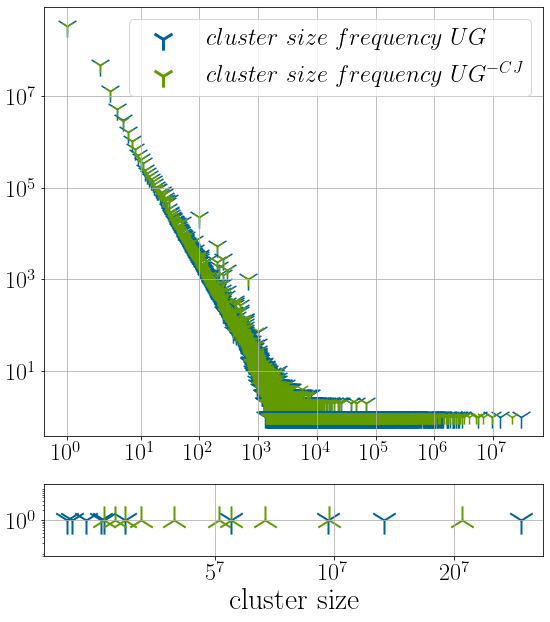

Largest Cluster includes the following services:
- Doubleinvestment.cf          (5,107,599 addresses)
- Doublecrypto.ml              (3,264,543 addresses)
- coinjoin                     (19,743 addresses)

2nd largest Cluster includes the following services:
- laxotrade                    (9,725,472 addresses)
- cryptory                     (1,564,802 addresses)
- f2pool.io                    (321,156 addresses)
- Polmine                      (290,682 addresses)
- Mtgox                        (152,557 addresses)
- Bitcoin-24.com-old-hotwallet (128,214 addresses)
- magic bitcoin doubler        (57,618 addresses)
- ePay.info                    (18,746 addresses)
- Coinjoin Bounty              (12,001 addresses)
- F2pool                       (11,572 addresses)
- doublebitcoin.life           (9,139 addresses)
- Unknown ransomware           (4,974 addresses)
- btcgains                     (4,852 addresses)
- Eligius.st                   (559 addresses)
- Mtgox hack                   (42 ad

In [11]:
dfcug = DF["usergraph_clustersizes_distribution_UG"][:-1].sort_values("clustersize")
dfcwj = DF["usergraph_clustersizes_distribution_WCJ"][:-1].sort_values("clustersize")

lc = DF["stats_largest_cluster_services"].dropna()
lc2 = DF["stats_2nd_largest_cluster_services"].dropna()
lc3 = DF["stats_3rd_largest_cluster_services"].dropna()


# Create figure 
f, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 9),
                       gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [3, 0.5]})

# Plot chart
axs[0].scatter(dfcug["clustersize"],dfcug["occurencies"], s=500, color="#00629b", alpha=1,
            marker="1", label=r"$cluster\ size\ frequency\ UG$")
axs[0].scatter(dfcwj["clustersize"],dfcwj["occurencies"], s=200, color="#629b00", 
            marker="1", label=r"$cluster\ size\ frequency\ UG^{-CJ}$")

axs[1].scatter(dfcug["clustersize"].iloc[-10:],dfcug["occurencies"].iloc[-10:], linewidth=2, s=800, color="#00629b", alpha=1,
            marker="1", label=r"$cluster\ size\ frequency\ UG$")
axs[1].scatter(dfcwj["clustersize"].iloc[-10:],dfcwj["occurencies"].iloc[-10:], linewidth=2, s=800, color="#629b00", 
            marker="2", label=r"$cluster\ size\ frequency\ UG^{-CJ}$")

# Customize ticks and labels
axs[0].set_xscale('symlog')
axs[0].set_yscale('log')
axs[0].tick_params(axis='both', which='major', labelsize=24)
axs[1].set_xscale('symlog')
axs[1].set_yscale('log')
axs[1].tick_params(axis='both', which='major', labelsize=24)
axs[1].set_xlabel("cluster size", fontsize=30)
axs[1].set_xticks([0.5e7, 1e7, 2e7])
axs[1].set_xticklabels(["$5^7$", "$10^7$", "$20^7$"])
axs[1].set_yticks([1])

# Legend
lgnd = axs[0].legend(fontsize=24)
lgnd.legendHandles[0]._sizes = [500]
lgnd.legendHandles[0]._linewidths = [3]
lgnd.legendHandles[1]._sizes = [500]
lgnd.legendHandles[1]._linewidths = [3]
plt.tight_layout(pad=2)

# Save figure and show
plt.savefig("./pictures/clustersize_dist.pdf")
plt.show()

print("Largest Cluster includes the following services:")
for _,i in lc.iterrows():
    print("- {:<28} ({:,.0f} addresses)".format(i["service"], i["c"]))
print("\n2nd largest Cluster includes the following services:")
for _,i in lc2.iterrows():
    print("- {:<28} ({:,.0f} addresses)".format(i["service"], i["c"]))
print("\n3rd largest Cluster includes the following services:")
for _,i in lc3.iterrows():
    print("- {:<28} ({:,.0f} addresses)".format(i["service"], i["c"]))

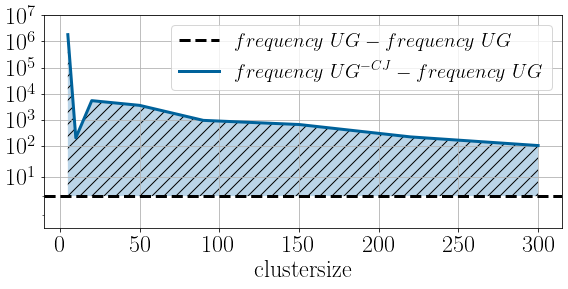

Differences:


array([1826140,     199,    5345,    3526,     935,     649,     217,
           101])

In [12]:
dfcug = DF["usergraph_clustersizes_distribution_UG"].sort_values("clustersize")
dfwcj = DF["usergraph_clustersizes_distribution_WCJ"].sort_values("clustersize")

n1    = dfcug.loc[(dfcug["clustersize"] >  0) & (dfcug["clustersize"] <= 5)]["occurencies"].sum()
n1wcj = dfwcj.loc[(dfwcj["clustersize"] >  0) & (dfwcj["clustersize"] <= 5)]["occurencies"].sum()
n2    = dfcug.loc[(dfcug["clustersize"] >  5) & (dfcug["clustersize"] <= 10)]["occurencies"].sum()
n2wcj = dfwcj.loc[(dfwcj["clustersize"] >  5) & (dfwcj["clustersize"] <= 10)]["occurencies"].sum()
n3    = dfcug.loc[(dfcug["clustersize"] >  10) & (dfcug["clustersize"] <= 20)]["occurencies"].sum()
n3wcj = dfwcj.loc[(dfwcj["clustersize"] >  10) & (dfwcj["clustersize"] <= 20)]["occurencies"].sum()
n4    = dfcug.loc[(dfcug["clustersize"] >  20) & (dfcug["clustersize"] <= 50)]["occurencies"].sum()
n4wcj = dfwcj.loc[(dfwcj["clustersize"] >  20) & (dfwcj["clustersize"] <= 50)]["occurencies"].sum()
n5    = dfcug.loc[(dfcug["clustersize"] >  50) & (dfcug["clustersize"] <= 90)]["occurencies"].sum()
n5wcj = dfwcj.loc[(dfwcj["clustersize"] >  50) & (dfwcj["clustersize"] <= 90)]["occurencies"].sum()
n6    = dfcug.loc[(dfcug["clustersize"] >  90) & (dfcug["clustersize"] <= 150)]["occurencies"].sum()
n6wcj = dfwcj.loc[(dfwcj["clustersize"] >  90) & (dfwcj["clustersize"] <= 150)]["occurencies"].sum()
n7    = dfcug.loc[(dfcug["clustersize"] >  150) & (dfcug["clustersize"] <= 220)]["occurencies"].sum()
n7wcj = dfwcj.loc[(dfwcj["clustersize"] >  150) & (dfwcj["clustersize"] <= 220)]["occurencies"].sum()
n8    = dfcug.loc[(dfcug["clustersize"] >  220) & (dfcug["clustersize"] <= 300)]["occurencies"].sum()
n8wcj = dfwcj.loc[(dfwcj["clustersize"] >  220) & (dfwcj["clustersize"] <= 300)]["occurencies"].sum()

a = np.array([n1,n2,n3,n4,n5,n6,n7,n8])
aa = np.array([5,10,20,50, 90, 150, 220, 300])
b = np.array([n1wcj,n2wcj,n3wcj,n4wcj,n5wcj,n6wcj,n7wcj,n8wcj])

# Create figure 
f, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 4),
                       gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [1]})


plt.axhline(0, color='black', lw=3, linestyle="dashed", label=r"$frequency\ UG - frequency\ UG$")
axs.plot(aa,b-a, color="#00629b", label=r'$frequency\ UG^{-CJ} - frequency\ UG$',linewidth=3)
axs.fill_between(aa,b-a, alpha=0.3, hatch=r"//")


axs.yaxis.get_offset_text().set_fontsize(24)
axs.set_xlabel('clustersize', fontsize=24)
axs.tick_params(axis='both', which='major', labelsize=24)

axs.set_yscale('symlog', linthresh=15)
plt.tight_layout()
axs.set_ylim(-20,1e7)
# Legend
axs.legend(fontsize=20)
axs.set_yticks([10, 1e2,1e3,1e4,1e5,1e6,1e7])

#Save figure and show
plt.savefig("./pictures/clustersize_comparison.pdf", bbox_inches = 'tight')
plt.show()
print("Differences:")
b-a

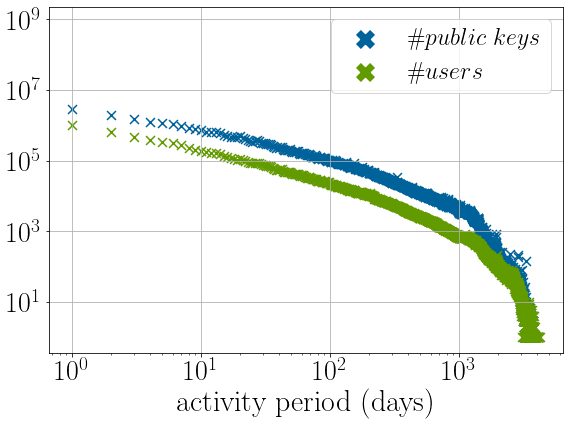

93.88% of addresses were used only on a single day (816,382,701)
95.32% of addresses were used for less than 10 days (828,925,894)
96.57% of users were seen only on a single day (370,005,877)
97.58% of users were seen for less than 10 days (373,871,118)
  2    publik keys were active for more than 4018 days (11 years)
  8    entities were active for more than 4018 days (11 years)

On average, users are active over a period of 10.19 days with a standard deviation of 81.87
On average, addresses are active over a period of 5.28 days with a standard deviation of 63.65
Most active public key: 17THx8KXVDnHM7arcoTxdvmYhS9rP141c2

Public keys:
      active_days  occurencies
3704         4136            1
3703         4056            1
3702         3976            1
3701         3948            1
3700         3932            1
...           ...          ...
4               4      1264056
3               3      1507174
2               2      1951001
1               1      2988979
0              

In [13]:
df_ent_active = DF["stats_active_time_G"][::-1]
df_uwcj       = DF["stats_active_time_WCJ"][::-1]
df_avgwcj     = DF["stats_active_time_avg_WCJ"].iloc[0]
df_avg        = DF["stats_active_time_avg_G"].iloc[0]


f, axs = plt.subplots(1, 1,figsize=(8, 6),gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [1]})

# Plot charts

axs.scatter(df_ent_active["active_days"],df_ent_active["occurencies"], s=80, color="#00629b",
               marker="x", label=r"$\# public\ keys$")
axs.scatter(df_uwcj["active_days"],df_uwcj["occurencies"], s=80, color="#629b00",
               marker="x", label=r"$\# users$")

# Customize ticks and labels
axs.tick_params(axis='both', which='major', labelsize=28)
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_xlabel("activity period (days)", fontsize=30)

# Legend
lgnd = axs.legend(fontsize=24)
lgnd.legendHandles[0]._linewidths = [7]
lgnd.legendHandles[1]._linewidths = [7]
lgnd.legendHandles[0]._sizes = [200]
lgnd.legendHandles[1]._sizes = [200]

plt.tight_layout(pad=1)
#Save figure and show
plt.savefig("./pictures/activity_period.pdf")
plt.show()
less10_ = sum(df_ent_active[df_ent_active["active_days"] < 10]["occurencies"])
less10 = round(less10_/sum(df_ent_active["occurencies"])*100, 2)     
less0_ = sum(df_ent_active[df_ent_active["active_days"] < 1]["occurencies"])
less0 = round(less0_/sum(df_ent_active["occurencies"])*100, 2)     

less10_u_ = sum(df_uwcj[df_uwcj["active_days"] < 10]["occurencies"])
less10_u = round(less10_u_/sum(df_uwcj["occurencies"])*100, 2)     
less0_u_ = sum(df_uwcj[df_uwcj["active_days"] < 1]["occurencies"])
less0_u = round(less0_u_/sum(df_uwcj["occurencies"])*100, 2)  

print("{}% of addresses were used only on a single day ({:,.0f})".format(less0,less0_))
print("{}% of addresses were used for less than 10 days ({:,.0f})".format(less10,less10_))

print("{}% of users were seen only on a single day ({:,.0f})".format(less0_u,less0_u_))
print("{}% of users were seen for less than 10 days ({:,.0f})".format(less10_u,less10_u_))

active = len(df_ent_active[df_ent_active["active_days"] >= 4018])
print("{:^6} publik keys were active for more than 4018 days (11 years)".format(active))
active = len(df_uwcj[df_uwcj["active_days"] >= 4018])
print("{:^6} entities were active for more than 4018 days (11 years)".format(active))
print("\nOn average, users are active over a period of {:,.2f} days with a standard deviation of {:,.2f}".format(df_avg[0], 
                                                                                                       math.sqrt(df_avg[1])))
print("On average, addresses are active over a period of {:,.2f} days with a standard deviation of {:,.2f}".format(df_avgwcj[0], 
                                                                                                         math.sqrt(df_avgwcj[1])))

print("Most active public key: {}".format(DF["stats_most_active_public_key"].iloc[0][0]))
print("\nPublic keys:")
print(df_ent_active)
print("\nUsers:")
print(df_uwcj)

In [14]:
less10 = sum(df_ent_active[df_ent_active["active_days"] < 10]["occurencies"])
less10 = round(less10/sum(df_ent_active["occurencies"])*100, 2)     
less0 = sum(df_ent_active[df_ent_active["active_days"] < 1]["occurencies"])
less0 = round(less0/sum(df_ent_active["occurencies"])*100, 2)     

less10_u = sum(df_uwcj[df_uwcj["active_days"] < 10]["occurencies"])
less10_u = round(less10_u/sum(df_uwcj["occurencies"])*100, 2)     
less0_u = sum(df_uwcj[df_uwcj["active_days"] < 1]["occurencies"])
less0_u = round(less0_u/sum(df_uwcj["occurencies"])*100, 2) 

### 3.4. Network Properties

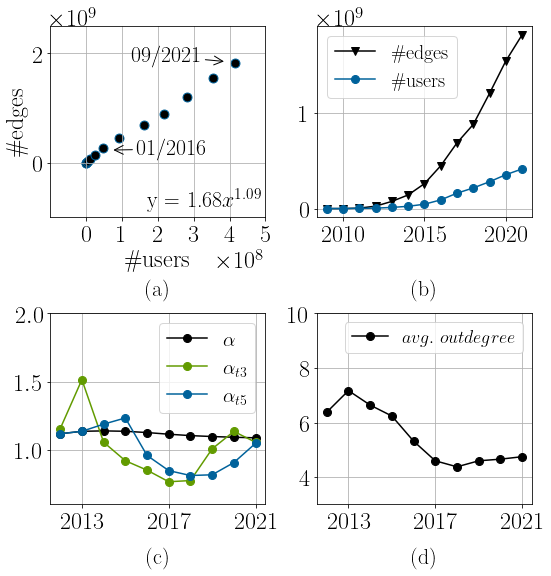

Total:          T3:             T5:            
2012 1.1180     2012 1.1549     2012 1.1180    
2013 1.1361     2013 1.5142     2013 1.1361    
2014 1.1391     2014 1.0563     2014 1.1883    
2015 1.1362     2015 0.9207     2015 1.2339    
2016 1.1270     2016 0.8515     2016 0.9593    
2017 1.1147     2017 0.7666     2017 0.8482    
2018 1.1046     2018 0.7753     2018 0.8123    
2019 1.0977     2019 1.0076     2019 0.8176    
2020 1.0925     2020 1.1352     2020 0.9072    
2021 1.0883     2021 1.0556     2021 1.0482    

Avg. out degree 2013: 7.17
Avg. out degree 2021: 4.75


In [15]:
# Densification

df_cncwcj = DF["stats_user_count_cum_WCJ"].sort_values("year").set_index("year")
df_out = DF["stats_avg_outdegree_WCJ"].sort_values("year", ignore_index=True)[3:]
df_out_ug = DF["stats_avg_outdegree_UG"].sort_values("year", ignore_index=True)[3:]
 
dense_pl = {}
for i in range(4,14):
    year = 2008 + i
    cnc, cec = df_cncwcj.addrs_c[0:i], df_cncwcj.edges_c[0:i]
    dense_pl[year],c = least_squares_line(cnc, cec)

dense_pl_t3 = {}   
dense_pl_t5 = {}
for i in range(4,14):
    year = 2008 + i
    cnc, cec = df_cncwcj.addrs_c[0:i], df_cncwcj.edges_c[0:i]
    dense_pl_t3[year],c = least_squares_line(cnc, cec, 3)
    dense_pl_t5[year],c = least_squares_line(cnc, cec, 5)  
        
    
equ = "y = " + str(round(c, 2)) +"$x^{" + str(round(dense_pl[2021], 2)) + "}$"

# Create figure with size 4x4 inches
f, axs = plt.subplots(2, 2,figsize=(8, 8))

# Plot chart
axs[0][0].scatter(df_cncwcj["addrs_c"],df_cncwcj["edges_c"], s=80, color="k", edgecolors="#00629b")
axs[1][0].plot(df_cncwcj.index[3:], dense_pl.values(), color="k", marker="o", markersize=8, label="$\\alpha$")
axs[1][0].plot(df_cncwcj.index[3:], dense_pl_t3.values(), color="#629b00", marker="o", markersize=8, label="$\\alpha_{t3}$")
axs[1][0].plot(df_cncwcj.index[3:], dense_pl_t5.values(), color="#00629b", marker="o", markersize=8, label="$\\alpha_{t5}$")
axs[0][1].plot(df_cncwcj.index, df_cncwcj["edges_c"], color="k", marker="v", markersize=8, label="\#edges")
axs[0][1].plot(df_cncwcj.index, df_cncwcj["addrs_c"], color="#00629b", marker="o", markersize=8, label="\#users")
axs[1][1].plot(df_out["year"], df_out["avg_outdegree"], color="k", marker="o", markersize=8, label="$avg.\ out\-degree$")


# Add month/year annoations
axs[0][0].annotate("09/2021", xy=(int(3.9e8), int(1.85e9)), xycoords='data',
            xytext=(int(1.25e8), int(1.85e9)), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"), fontsize=22)
axs[0][0].annotate("01/2016", xy=(int(0.7e8), int(0.23e9)), xycoords='data',
            xytext=(int(1.4e8), int(0.15e9)), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"), fontsize=22)

axs[0][0].annotate(equ, xy=(int(1.7e8), int(-8e8)), xycoords='data',
            xytext=(int(1.7e8), int(-8e8)), textcoords='data', fontsize=22)


axs[0][0].set_xlabel('\#users', fontsize=24)
axs[0][0].set_ylabel('\#edges', fontsize=24)
axs[0][0].xaxis.get_offset_text().set_fontsize(24)
axs[0][0].yaxis.get_offset_text().set_fontsize(24)
axs[0][1].yaxis.get_offset_text().set_fontsize(24)
axs[0][1].xaxis.set_ticks([2010,2015,2020])
axs[1][0].xaxis.set_ticks([2013,2017,2021])
axs[1][1].xaxis.set_ticks([2013,2017,2021])
axs[0][0].set_xticks([0, 1e8, 2e8, 3e8, 4e8, 5e8])
axs[1][1].set_yticks([4, 6, 8, 10])
axs[1][0].set_ylim([0.6, 2])
axs[1][1].set_ylim(3, 10)
axs[0][0].set_ylim(-1e9, 0.25e10)
axs[0][0].set_xlim(-1e8, 5e8)
axs[0][1].legend(fontsize=20)
axs[1][0].legend(fontsize=20)
axs[1][1].legend(fontsize=18)
axs[0][0].tick_params(axis='both', which='major', labelsize=24)
axs[0][1].tick_params(axis='both', which='major', labelsize=24)
axs[1][0].tick_params(axis='both', which='major', labelsize=24)
axs[1][1].tick_params(axis='both', which='major', labelsize=24)
axs[0][0].set_title('(a)', y=1.0, pad=-270, fontsize=22)
axs[0][1].set_title('(b)', y=1.0, pad=-270, fontsize=22)
axs[1][0].set_title('(c)', y=1.0, pad=-250, fontsize=22)
axs[1][1].set_title('(d)', y=1.0, pad=-250, fontsize=22)

plt.tight_layout(pad=1)
#Save figure and show
plt.savefig("./pictures/densification_over_time.pdf")
plt.show()

print("{:<15} {:<15} {:<15}".format("Total:", "T3:", "T5:"))
for i in zip(dense_pl.items(),dense_pl_t3.items(),dense_pl_t5.items()):
    print("{:<5}{:<10.4f} {:<5}{:<10.4f} {:<5}{:<10.4f}".format(i[0][0],i[0][1],i[1][0],i[1][1],i[2][0],i[2][1]))

print("\nAvg. out degree {}: {}".format(int(df_out.iloc[1][0]), df_out.iloc[1][1]))
print("Avg. out degree {}: {}".format(int(df_out.iloc[-1][0]), df_out.iloc[-1][1]))

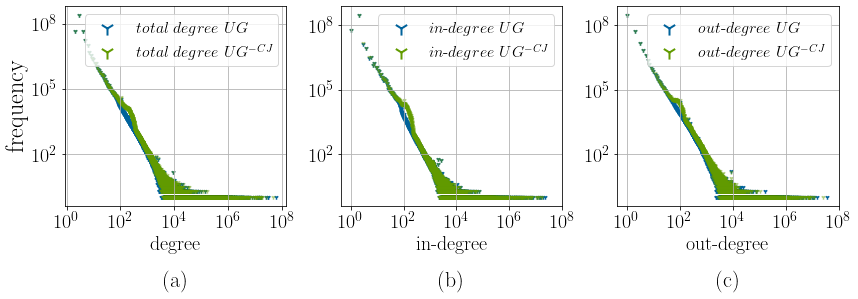

In [16]:
# DEGREE DISTRIBUTION 
#
# The power law coefficients are calculated using plfit.c, available
# here https://github.com/ntamas/plfit 

df_ddt = DF["stats_degree_distribution_total_UG"]
df_ddi = DF["stats_degree_distribution_out_degree_UG"]
df_ddo = DF["stats_degree_distribution_in_degree_UG"]

df_ddt_wcj = DF["stats_degree_distribution_total_WCJ"]
df_ddi_wcj = DF["stats_degree_distribution_out_degree_WCJ"]
df_ddo_wcj = DF["stats_degree_distribution_in_degree_WCJ"]

# Create figure with size 4x4 inches
f, axs = plt.subplots(1, 3,figsize=(12, 4))

# Plot total degree
axs[0].scatter(df_ddt["degree"],df_ddt["frequency"], s=20, color="#00629b", marker="1", label="$total\ degree\ UG$")
axs[0].scatter(df_ddt_wcj["degree"],df_ddt_wcj["frequency"], s=20, color="#629b00", alpha=0.5, marker="1", label="$total\ degree\ UG^{-CJ}$")

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].set_xlabel('degree', fontsize=20)
axs[0].set_ylabel('frequency', fontsize=24)
axs[0].set_xticks([1, 1e2, 1e4, 1e6, 1e8])

# Plot in degree
axs[1].scatter(df_ddi["degree"],df_ddi["frequency"], s=20, color="#00629b", marker="1", label="$in$-$degree\ UG$")
axs[1].scatter(df_ddi_wcj["degree"],df_ddi_wcj["frequency"], s=20, color="#629b00", alpha=0.5, marker="1", label="$in$-$degree\ UG^{-CJ}$")
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('in-degree', fontsize=20)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].set_xticks([1, 1e2, 1e4, 1e6, 1e8])

# Plot out degree
axs[2].scatter(df_ddo["degree"],df_ddo["frequency"], s=20, color="#00629b", marker="1", label="$out$-$degree\ UG$")
axs[2].scatter(df_ddo_wcj["degree"],df_ddo_wcj["frequency"], s=20, color="#629b00", alpha=0.5, marker="1", label="$out$-$degree\ UG^{-CJ}$")
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel('out-degree', fontsize=20)
axs[2].tick_params(axis='both', which='major', labelsize=20)
axs[2].set_xticks([1, 1e2, 1e4, 1e6, 1e8])

axs[0].set_title('(a)', y=1.0, pad=-280, fontsize=22)
axs[1].set_title('(b)', y=1.0, pad=-280, fontsize=22)
axs[2].set_title('(c)', y=1.0, pad=-280, fontsize=22)

lgnd1 = axs[0].legend(fontsize=16)


lgnd2 = axs[1].legend(fontsize=16)
lgnd3 = axs[2].legend(fontsize=16)


lgnd1.legendHandles[0]._linewidths = [2]
lgnd1.legendHandles[1]._linewidths = [2]
lgnd1.legendHandles[0]._sizes = [200]
lgnd1.legendHandles[1]._sizes = [200]
lgnd1.legendHandles[1]._alpha = 1

lgnd2.legendHandles[0]._linewidths = [2]
lgnd2.legendHandles[1]._linewidths = [2]
lgnd2.legendHandles[0]._sizes = [200]
lgnd2.legendHandles[1]._sizes = [200]
lgnd2.legendHandles[1]._alpha = 1

lgnd3.legendHandles[0]._linewidths = [2]
lgnd3.legendHandles[1]._linewidths = [2]
lgnd3.legendHandles[0]._sizes = [200]
lgnd3.legendHandles[1]._sizes = [200]
lgnd3.legendHandles[1]._alpha = 1

plt.tight_layout(pad=1)
#Save figure and show
plt.savefig("./pictures/degree_distributions.pdf", bbox_inches='tight')
plt.show()

In [17]:
# Create degree files to calculate power law exponent
%run bitcoin_graph/create_degree_file.py

input path to store degree-file: .tmp/powerlaw_distribution
1/3
2/3
3/3


<Figure size 432x288 with 0 Axes>

In [18]:
# Calculate power law exponents using plfit.c (https://github.com/ntamas/plfit)
! ./plfit/build/src/plfit .tmp/powerlaw_distribution_total.txt

.tmp/powerlaw_distribution_total.txt:
	Discrete MLE
	alpha =      1.82797
	xmin  =  11884.00000
	L     = -85719.13840
	D     =      0.01002



In [19]:
! ./plfit/build/src/plfit .tmp/powerlaw_distribution_in.txt

.tmp/powerlaw_distribution_in.txt:
	Discrete MLE
	alpha =      2.17628
	xmin  =    196.00000
	L     = -3217116.80798
	D     =      0.00654



In [20]:
! ./plfit/build/src/plfit .tmp/powerlaw_distribution_out.txt

.tmp/powerlaw_distribution_out.txt:
	Discrete MLE
	alpha =      1.93258
	xmin  =  47903.00000
	L     = -14495.13709
	D     =      0.01417



In [21]:
a = DF["stats_degree_in_largest_services_UG"]
b = DF["stats_degree_out_largest_services_UG"]
c = a[a['clusterid'].isin(b["clusterid"])].set_index("clusterid").join(b.set_index("clusterid").drop("service", axis=1), on=None, how='inner')
c["total_degree"] = c["in_degrees"]+c["out_degrees"]
c = c.sort_values("total_degree", ascending=False)
d = DF["stats_degree_in_largest_services_WCJ"]
e = DF["stats_degree_out_largest_services_WCJ"]
f = d[d['clusterid'].isin(e["clusterid"])].set_index("clusterid").join(e.set_index("clusterid").drop("service", axis=1), on=None, how='inner')
f["total_degree"] = f["in_degrees"]+f["out_degrees"]
f = f.sort_values("total_degree", ascending=False)

# Table in LATEX format
g = c.dropna().set_index("service").join(f.set_index("service"), on=None, how="inner", lsuffix="_UG", rsuffix="_WCJ")
g["difference"] = g["total_degree_UG"] - g["total_degree_WCJ"]
g = g.reset_index().groupby(by="service").sum()
g = g.sort_values("difference", ascending=False)

print("$ service $& $ degree_{UG}$ & $degree_{UG^{-CJ}}$& $\delta$ \\\ \n\hline")

for i, j in g.iloc[np.r_[0:4, -6:0]].iterrows():
    if i[0].lower() == i[0]:
        i = i[0].upper() + i[1:]

    print("{:<16} & {:>10,.0f} & {:>10,.0f} & {:>10,.0f} \\\ ".format(i, j["total_degree_UG"], j["total_degree_WCJ"], j["difference"]))

$ service $& $ degree_{UG}$ & $degree_{UG^{-CJ}}$& $\delta$ \\ 
\hline
Doublecrypto.ml  & 58,249,388 &  7,524,361 & 50,725,027 \\ 
SatoshiDice.com-original & 24,534,119 &    219,919 & 24,314,200 \\ 
Laxotrade        & 30,057,625 & 16,834,191 & 13,223,434 \\ 
Sextortion Spam  & 12,232,121 &  3,838,573 &  8,393,548 \\ 
BitPay.com       &    629,596 &  2,711,720 & -2,082,124 \\ 
PrimeDice.com    &    827,512 &  3,366,755 & -2,539,243 \\ 
Bitstamp.net     &    921,016 &  4,101,274 & -3,180,258 \\ 
Kraken.com       &  5,965,974 & 12,002,222 & -6,036,248 \\ 
Huobi.com        &    220,012 &  8,964,760 & -8,744,748 \\ 
Binance hack     & 12,156,537 & 63,180,075 & -51,023,538 \\ 


### 3.5. Additional Material

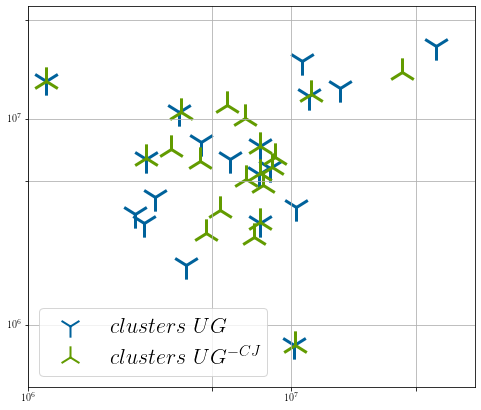

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 7),
                       gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [1]})
# Plot chart

axs.scatter(c["in_degrees"].iloc[0:20],c["out_degrees"].iloc[0:20], s=800, color="#00629b", alpha=1,
            marker="1", label=r"$clusters\ UG$", linewidths=3)


axs.scatter(f["in_degrees"].iloc[0:20],f["out_degrees"].iloc[0:20], s=800, color="#629b00", alpha=1,
            marker="2", label=r"$clusters\ UG^{-CJ}$", linewidths=3)


axs.set_ylim(5e5,35e6)
axs.set_xlim(10e5,0.5e8)
axs.set_yscale('symlog')
axs.set_xscale('symlog')

lgnd1 = axs.legend(fontsize=22)
lgnd1.legendHandles[0]._linewidths = [2]
lgnd1.legendHandles[1]._linewidths = [2]

lgnd1.legendHandles[0]._sizes = [500]
lgnd1.legendHandles[1]._sizes = [500]

axs.xaxis.set_ticks([1e6,5e6,1e7,3e7])
axs.yaxis.set_ticks([1e6,5e6,1e7,3e7])

plt.show()

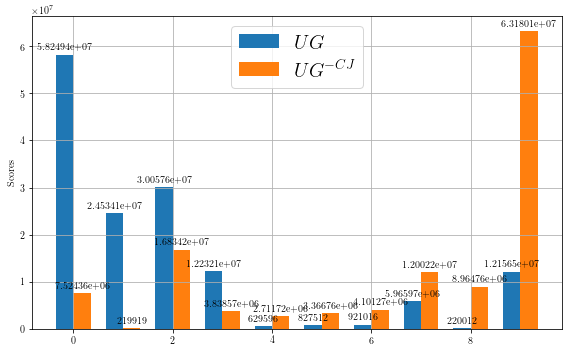

In [24]:
_g = g.iloc[np.r_[0:4, -6:0]]
fig, ax = plt.subplots(figsize=(8,5))

labels = list(_g.index)
men_means = _g["total_degree_UG"]
women_means = _g["total_degree_WCJ"]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, men_means, width, label='$UG$')
rects2 = ax.bar(x + width/2, women_means, width, label='$UG^{-CJ}$')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')

ax.legend(fontsize=20)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()